In [1]:
import pandas as pd
import os
os.chdir("/home/yangkai/codegen-detection")

In [2]:
hum_data = pd.read_pickle("dataset/apps_hum_test.pkl")
gen_data = pd.read_pickle("dataset/apps_gen_test.pkl")

# hum_data = pd.read_pickle("dataset/csn_1k_hum_test.pkl")
# gen_data = pd.read_pickle("dataset/csn_gpt_gen_test.pkl")
hum_data['label'] = 0
gen_data['label'] = 1

In [3]:
hum_len = hum_data['extracted_full_func'].apply(len)
gen_len = gen_data['extracted_full_func'].apply(len)

In [10]:
def get_data_range(s,e,df1,df2):
    lens = df1['extracted_full_func'].apply(len)
    selected1 = df1[(lens >=s) & (lens < e)]
    
    lens = df2['extracted_full_func'].apply(len)
    selected2 = df2[(lens >=s) & (lens < e)]

    min_len = min(len(selected1),len(selected2))
    

    return selected1.sample(min_len,random_state=42),selected2.sample(min_len,random_state=42)

sampled_gen,sampled_hum = get_data_range(0,100,gen_data,hum_data)

In [22]:
from sklearn.metrics import roc_auc_score,average_precision_score
import numpy as np

def word_prob_gather_fn(word_prob):
    try:
        assert len(word_prob) > 0
    except:
        return 0
    if model != 'code-cushman-001':
        log_prob = np.log(np.array(word_prob) + 1e-6)
    else:
        log_prob = np.array(word_prob)
    avg_log_prob = log_prob.sum() / (len(log_prob) + 1e-6)
    return avg_log_prob

def entropy_gather_fn(entropy):
    try:
        assert len(entropy) > 0
    except:
        return 0
    entropy = np.array(entropy)
    
    avg_entropy = entropy.sum() / (len(entropy) + 1e-6)
    return -avg_entropy

def log_rank_gather_fn(word_rank):
    try:
        assert len(word_rank) > 0
    except:
        return 0
    log_rank = np.log(np.array(word_rank) + 1)
    avg_log_rank = log_rank.sum() / (len(log_rank) + 1e-6)
    return -avg_log_rank

def rank_gather_fn(word_rank):
    try:
        assert len(word_rank) > 0
    except:
        return 0
    log_rank = np.array(word_rank) + 1
    avg_log_rank = log_rank.sum() / (len(log_rank) + 1e-6)
    return -avg_log_rank

In [30]:
ranges = [(0,200),(200,400),(400,600),(600,1000),(1000,1000000000)]
hum_column_prefix = 'extracted_full_func_'
gen_column_prefix = 'extracted_full_func_'
for s,e in ranges:
    sampled_gen,sampled_hum = get_data_range(s,e,gen_data,hum_data)
    
    models = ['codegen-2B-mono','incoder-6B','llama-13b','starcoder']
    score_names = ['log_prob','rank','log_rank','entropy']
    feat_name_dict = {'log_prob':"word_prob","rank":"word_rank","log_rank":"word_rank","entropy":"entropy"}
    name2gatherfn = {"log_prob":word_prob_gather_fn,"rank":rank_gather_fn,"log_rank":log_rank_gather_fn,"entropy":entropy_gather_fn}
    result_df = pd.DataFrame(index=score_names,columns=models)
    all_data = pd.concat([sampled_gen,sampled_hum])
    for model in models:
        for score in score_names:
            # print(model,score)
            hum_column_name = hum_column_prefix + f"{feat_name_dict[score]}_{model}"
            gen_column_name = gen_column_prefix + f"{feat_name_dict[score]}_{model}"
            
            all_feat = pd.concat([sampled_gen[gen_column_name],sampled_hum[hum_column_name]])

            all_score = all_feat.apply(name2gatherfn[score]).tolist()
            all_label = all_data['label']
            roc = roc_auc_score(all_label,all_score)
            result_df[model][score] = round(roc,2)
    result_df['avg'] = result_df.mean(axis=1)
    print(s,e,len(sampled_gen))
    print(result_df)

0 200 193
         codegen-2B-mono incoder-6B llama-13b starcoder     avg
log_prob            0.57       0.51      0.56      0.53  0.5425
rank                0.49       0.51      0.45      0.47    0.48
log_rank            0.55        0.5      0.53      0.52   0.525
entropy              0.5       0.56      0.53      0.48  0.5175
200 400 219
         codegen-2B-mono incoder-6B llama-13b starcoder     avg
log_prob            0.72       0.66      0.73       0.7  0.7025
rank                0.55       0.52      0.51      0.49  0.5175
log_rank            0.68       0.65      0.69      0.67  0.6725
entropy             0.66       0.62      0.68       0.6    0.64
400 600 121
         codegen-2B-mono incoder-6B llama-13b starcoder     avg
log_prob             0.7       0.65      0.71      0.68   0.685
rank                0.52       0.51      0.36      0.46  0.4625
log_rank            0.66       0.63      0.64      0.64  0.6425
entropy             0.65        0.6      0.66      0.58  0.6225
600 10

In [32]:
hum_perturb = pd.read_pickle("dataset/apps_hum_test_perturb_ident_10.pkl")
gen_perturb = pd.read_pickle("dataset/apps_gen_test_perturb_ident_10.pkl")
df = pd.DataFrame(index=['DetectGPT'],columns=models)
for s,e in ranges:
    sampled_gen,sampled_hum = get_data_range(s,e,gen_data,hum_data)
    for model in models:
        column_name = f"extracted_full_func_word_prob_{model}"
        hum_score = []
        for pid,orig_prob in zip(sampled_hum['problem_id'],sampled_hum[column_name]):
            orig_prob = word_prob_gather_fn(orig_prob)
            perturb_probs = hum_perturb[hum_perturb.problem_id == pid][column_name].apply(word_prob_gather_fn)
            if len(perturb_probs) == 0:
                hum_score.append(0)
                continue
            perturb_prob = perturb_probs.mean()
            prob_diff = orig_prob - perturb_prob
            hum_score.append(prob_diff)
        
        gen_score = []
        for pid,orig_prob in zip(sampled_gen['problem_id'],sampled_gen[column_name]):
            orig_prob = word_prob_gather_fn(orig_prob)
            perturb_probs = gen_perturb[gen_perturb.problem_id == pid][column_name].apply(word_prob_gather_fn)
            if len(perturb_probs) == 0:
                gen_score.append(0)
                continue
            perturb_prob = perturb_probs.mean()
            prob_diff = orig_prob - perturb_prob
            gen_score.append(prob_diff)
        
        scores = gen_score + hum_score
        labels = [1] * len(gen_score) + [0] * len(hum_score)
        roc = roc_auc_score(labels,scores)
        df[model]['DetectGPT'] = round(roc,2)

    df['avg'] = df.mean(axis=1)
    print(s,e,len(sampled_gen))
    print(df)
        

0 200 193
          codegen-2B-mono incoder-6B llama-13b starcoder     avg
DetectGPT            0.47       0.52      0.49      0.49  0.4925
200 400 219
          codegen-2B-mono incoder-6B llama-13b starcoder     avg
DetectGPT            0.62       0.66      0.66      0.62  0.6105
400 600 121
          codegen-2B-mono incoder-6B llama-13b starcoder     avg
DetectGPT            0.71       0.73      0.74      0.73  0.7041
600 1000 99
          codegen-2B-mono incoder-6B llama-13b starcoder      avg
DetectGPT             0.8       0.79      0.84       0.8  0.78682
1000 1000000000 43
          codegen-2B-mono incoder-6B llama-13b starcoder       avg
DetectGPT             0.9       0.92      0.94      0.92  0.893364


In [33]:
from simcse.simcse import RobertaForCL
from transformers import AutoTokenizer
device = 5
model_args = {'pooler_type':'cls','temp':0.1,'mlp_only_train':True}
model = RobertaForCL.from_pretrained("simcse/ckpt_gcb4_full/best_model",**model_args)

# model_args = {'pooler_type':'cls','temp':0.1,'mlp_only_train':True}
# model = RobertaForCL.from_pretrained("microsoft/graphcodebert-base",**model_args)

tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
model = model.to(device)

/home/yangkai/anaconda3/envs/torch20-cu117/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'pooler_type': 'cls', 'temp': 0.1, 'mlp_only_train': True}


In [34]:
import torch
from tqdm import tqdm
bsz = 32

@torch.inference_mode()
def pipeline(texts):
    inputs = tokenizer(texts,return_tensors='pt',padding=True,add_special_tokens=True,truncation=True)
    inputs = {k:v.to(device) for k,v in inputs.items()}
    sent_embed = model(**inputs,sent_emb=True).pooler_output

    return sent_embed

@torch.inference_mode()
def batch_encode(texts):
    embeds = []
    for i in tqdm(range(0,len(texts),bsz)):
        chunk = texts[i:i+bsz]
        embeds.append(pipeline(chunk))
    
    return torch.cat(embeds,dim=0)

In [38]:
# gen_resample_keys = ['gpt_resample-nocot_code_cleaned1','gpt_resample-nocot_code_cleaned2']
gen_resample_keys = ['starcoder_resample_code_cleaned'] + [f'starcoder_resample_code_cleaned{i}' for i in range(2,9)]
gen_orig_key = 'extracted_full_func'

hum_resample_keys = ['starcoder_resample_code_cleaned'] + [f'starcoder_resample_code_cleaned{i}' for i in range(2,9)]
hum_orig_key = 'extracted_full_func'

In [39]:
def get_sim(data,resample_keys,orig_key):
    orig_embed = batch_encode(data[orig_key].tolist())
    resample_embeds = []
    for key in resample_keys:
        resample_embeds.append(batch_encode(data[key].tolist()))
    
    all_sim = []
    normed_orig_embed = torch.nn.functional.normalize(orig_embed,p=2,dim=-1)
    for embed in resample_embeds:
        normed_embed = torch.nn.functional.normalize(embed,p=2,dim=-1)
        sim = (normed_orig_embed * normed_embed).sum(-1)
        all_sim.append(sim)
    
    return all_sim

gen_sim = get_sim(gen_data,gen_resample_keys,gen_orig_key)
hum_sim = get_sim(hum_data,hum_resample_keys,hum_orig_key)

100%|██████████| 25/25 [00:05<00:00,  4.81it/s]


In [42]:
m = 8

gen_score = sum([gen_sim[i] for i in range(m)]) / m
hum_score = sum([hum_sim[i] for i in range(m)]) / m

In [45]:
gen_data['avg_sim_score'] = gen_score.tolist()
hum_data['avg_sim_score'] = hum_score.tolist()

In [46]:
for s,e in ranges:
    sampled_gen,sampled_hum = get_data_range(s,e,gen_data,hum_data)
    all_sampled = pd.concat([sampled_gen,sampled_hum])
    sim_score = all_sampled['avg_sim_score']
    label = all_sampled['label']
    score = roc_auc_score(label,sim_score)
    print(s,e,score)

0 200 0.6506483395527397
200 400 0.7685619565897291
400 600 0.8139471347585547
600 1000 0.8143046627895114
1000 1000000000 0.8404542996214169


Text(0.5, 0, 'Code Length')

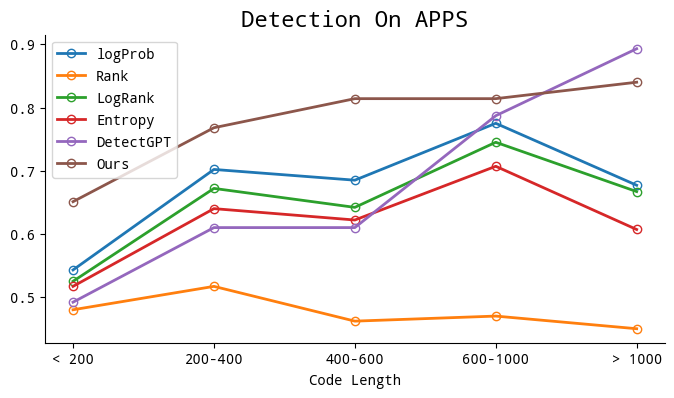

In [49]:
import pandas as pd
import os
import matplotlib.pyplot as plt
os.chdir("/home/yangkai/codegen-detection")
plt.rc('font', family='Noto Mono', size=10, weight='bold')
plt.figure(figsize=(8,4),dpi=100)
plt.subplot(1,1,1)
names = ['logProb','Rank','LogRank','Entropy','DetectGPT','Ours']
xticks = ['< 200','200-400','400-600','600-1000','> 1000']
scores1 = [0.543,0.480,0.525,0.517,0.492,0.651]
scores2 = [0.702,0.517,0.672,0.640,0.610,0.768]
scores3 = [0.685,0.462,0.642,0.622,0.610,0.814]
scores4 = [0.775,0.470,0.745,0.707,0.787,0.814]
socres5 = [0.677,0.450,0.667,0.607,0.893,0.840]


for i,name in enumerate(names):
    scores = [scores1[i],scores2[i],scores3[i],scores4[i],socres5[i]]
    plt.plot(xticks,scores,label=name,marker="o",fillstyle='none',ms=6,linewidth=2)

ax=plt.gca()
ax.set_title("Detection On APPS",font='Noto Mono',size=16,fontweight='heavy')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()
plt.xlabel('Code Length')
plt.savefig("visuals/vary_codelength.pdf",format="pdf",bbox_inches="tight")